In [2]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize # To resize images if needed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


families = os.listdir('data')

## Exploration


In [3]:
# Initialize an empty list to store all sample information
all_samples = []
family_counts = {}

for family in families:
    family_path = os.path.join('data', family)
    if os.path.isdir(family_path):
        png_files = [f for f in os.listdir(family_path) if f.endswith('.png')]
        family_counts[family] = len(png_files)

        for sample in png_files:
            sample_path = os.path.join(family_path, sample)
            img = imread(sample_path)
            channels = img.shape[2] if len(img.shape) > 2 else 1
            all_samples.append({
                'Family': family,
                'Width': img.shape[1],
                'Height': img.shape[0],
                'Channels': channels,
                'Size': img.size,
                'Path': sample_path
            })

samples_df = pd.DataFrame(all_samples)

family_df = pd.DataFrame(list(family_counts.items()), columns=['Family', 'Count'])
family_df = family_df.sort_values('Count', ascending=False)

print(f"There are {len(family_df)} malware families and a total of {family_df['Count'].sum()} samples.")

family_df

There are 25 malware families and a total of 9339 samples.


,Family,Count
12,Allaple.A,2949
23,Allaple.L,1591
14,Yuner.A,800
1,Instantaccess,431
13,VB.AT,408
10,Fakerean,381
7,Lolyda.AA1,213
5,C2LOP.gen!g,200
24,Alueron.gen!J,198
20,Lolyda.AA2,184


In [4]:
low_sample_threshold = family_df['Count'].median() * 0.2  
small_families = family_df[family_df['Count'] < low_sample_threshold]
if not small_families.empty:
    print(f"\nFamilies with few samples (less than {low_sample_threshold:.0f}):")
    print(small_families)
    print("\nConsideration: These families with few samples might be candidates for removal")
    print(f"to avoid class imbalance issues. They represent {small_families['Count'].sum()/family_df['Count'].sum()*100:.2f}% of total data.")
else:
    print('No families with less than 20% of the median number of samples.')

No families with less than 20% of the median number of samples.


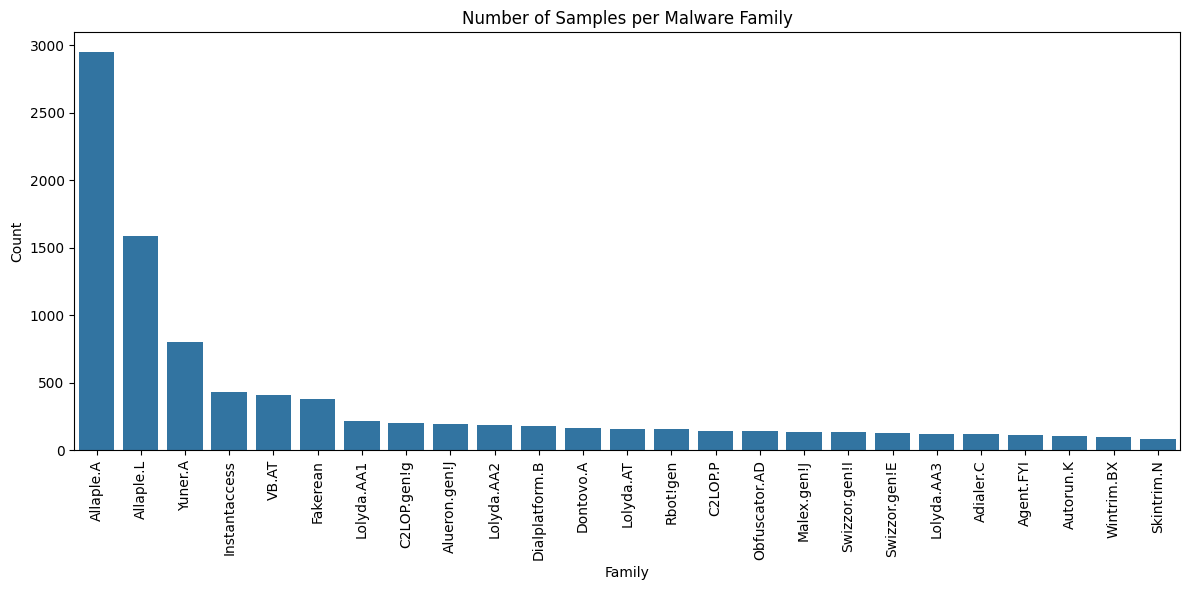

<Figure size 1500x1000 with 0 Axes>

In [5]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Family', y='Count', data=family_df)
plt.title('Number of Samples per Malware Family')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

threshold = family_df['Count'].median() * 0.2  
small_families = family_df[family_df['Count'] < threshold]
if not small_families.empty:
    print(f"\nFamilies with few samples (less than {threshold:.0f}):")
    print(small_families)
    print("\nConsideration: These families with few samples might be candidates for removal")
    print(f"to avoid class imbalance issues. They represent {small_families['Count'].sum()/family_df['Count'].sum()*100:.2f}% of total data.")

plt.figure(figsize=(15, 10))
sample_count = min(3, len(families))  
for i, family in enumerate(families[:sample_count]):
    family_path = os.path.join('/data', family)
    if os.path.isdir(family_path):
        samples = [f for f in os.listdir(family_path) if f.endswith('.png')]
        sample_count_per_family = min(3, len(samples))  
        
        for j, sample in enumerate(samples[:sample_count_per_family]):
            sample_path = os.path.join(family_path, sample)
            plt.subplot(sample_count, sample_count_per_family, i*sample_count_per_family + j + 1)
            img = imread(sample_path)
            plt.imshow(img)
            plt.title(f"{family}: {sample}")
            plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
print("Summary statistics for Width:")
print(samples_df['Width'].describe())
print("\nSummary statistics for Height:")
print(samples_df['Height'].describe())

Summary statistics for Width:
count    9339.000000
mean      334.171967
std       218.421689
min        64.000000
25%       128.000000
50%       256.000000
75%       512.000000
max      1024.000000
Name: Width, dtype: float64

Summary statistics for Height:
count    9339.000000
mean      436.814541
std       203.640501
min       208.000000
25%       281.000000
50%       424.000000
75%       467.000000
max      5334.000000
Name: Height, dtype: float64


In [7]:
unique_channels = samples_df['Channels'].unique()
print(f"\nUnique channel values found: {unique_channels}")
if len(unique_channels) == 1:
    print(f"All images have {unique_channels[0]} channel(s).")
    if unique_channels[0] == 1:
        print("(grayscale)")
    elif unique_channels[0] == 3:
         print("(RGB color)")
else:
    print("Warning: Images have varying numbers of channels.")



Unique channel values found: [1]
All images have 1 channel(s).
(grayscale)


In [8]:
same_dimensions = (samples_df['Width'].nunique() == 1) and (samples_df['Height'].nunique() == 1)
if same_dimensions:
    print(f"\nAll images have the same dimensions: {samples_df['Width'].iloc[0]}x{samples_df['Height'].iloc[0]}")
    img_height = samples_df['Height'].iloc[0]
    img_width = samples_df['Width'].iloc[0]
else:
    print("\nImages have varying dimensions.")
    most_common_dims = samples_df.groupby(['Width', 'Height']).size().idxmax()
    print(f"The most common dimensions are: {most_common_dims[0]}x{most_common_dims[1]}")


Images have varying dimensions.
The most common dimensions are: 128x452


## Model


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_HEIGHT = 64    
IMG_WIDTH = 64     
IMG_CHANNELS = 1   # Grayscale.
NUM_CLASSES = len(samples_df['Family'].unique()) # All of them since no family has a lower number of samples than the threshold.

model = keras.Sequential(
    [
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"), 
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="basic_malware_cnn" # Give your model a name
)


model.summary()

print("\n--- Compiling Model ---")
model.compile(
    loss="categorical_crossentropy", # Use 'categorical...' for multi-class when labels are one-hot encoded
    optimizer="adam",                # Adam is a popular and generally effective optimizer
    metrics=["accuracy"]             # Track accuracy during training and evaluation
)
print("Model compiled successfully.")

Model: "basic_malware_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,321 (8.08 MB)

 Trainable params: 2,119,321 (8.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Compiling Model ---
Model compiled successfully.


In [10]:
print("Preparing labels...")
# Use LabelEncoder to convert family names (strings) into integers (0, 1, 2...)
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(samples_df['Family'])

Preparing labels...


In [11]:
# One-hot encode the integer labels
# This converts labels like '2' into [0, 0, 1, 0...] based on NUM_CLASSES
y = tf.keras.utils.to_categorical(integer_encoded_labels, num_classes=NUM_CLASSES)
print(f"Labels shape: {y.shape}") # Should be (num_samples, NUM_CLASSES)

Labels shape: (9339, 25)


In [12]:
print("Loading and preprocessing images...")
X_list = []
# Ensure paths are correct and iterate through the DataFrame
for img_path in samples_df['Path']:
    try:
        # Load image using tensorflow - handles various formats and simplifies channel handling
        img = tf.keras.preprocessing.image.load_img(
            img_path,
            color_mode='grayscale', # Ensures IMG_CHANNELS = 1
            target_size=(IMG_HEIGHT, IMG_WIDTH) # Resizes the image
        )
        # Convert image to numpy array and normalize pixel values to [0, 1]
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        X_list.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        # Optional: handle missing/corrupt images (e.g., append a placeholder or skip)
        # For now, we'll let it raise an error if something critical fails.

# Convert the list of image arrays into a single NumPy array
X = np.array(X_list)
print(f"Features (images) shape: {X.shape}") # Should be (num_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# --- Check if X and y have the same number of samples ---
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels!"

Loading and preprocessing images...
Features (images) shape: (9339, 64, 64, 1)


In [15]:
print("Splitting data into training and testing sets...")
# Use stratify=y to ensure class distribution is similar in train and test sets
# We use integer_encoded_labels for stratification before they were one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,       # 30% for testing
    random_state=42,      # For reproducible results
    stratify=integer_encoded_labels # Use integer labels for stratification
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Splitting data into training and testing sets...
X_train shape: (6537, 64, 64, 1), y_train shape: (6537, 25)
X_test shape: (2802, 64, 64, 1), y_test shape: (2802, 25)



--- Training Model ---
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5236 - loss: 1.6561 - val_accuracy: 0.8616 - val_loss: 0.4110
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9381 - loss: 0.2436 - val_accuracy: 0.9572 - val_loss: 0.1398
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9653 - loss: 0.1289 - val_accuracy: 0.9656 - val_loss: 0.1088
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9791 - loss: 0.0711 - val_accuracy: 0.9549 - val_loss: 0.1225
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9814 - loss: 0.0502 - val_accuracy: 0.9725 - val_loss: 0.0870
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9953 - loss: 0.0211 - val_accuracy: 0.9694 - val_loss: 0.1077
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9977 - loss: 0.0115 - val_accuracy: 0.9778 - val_loss: 0.0745
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9984 -

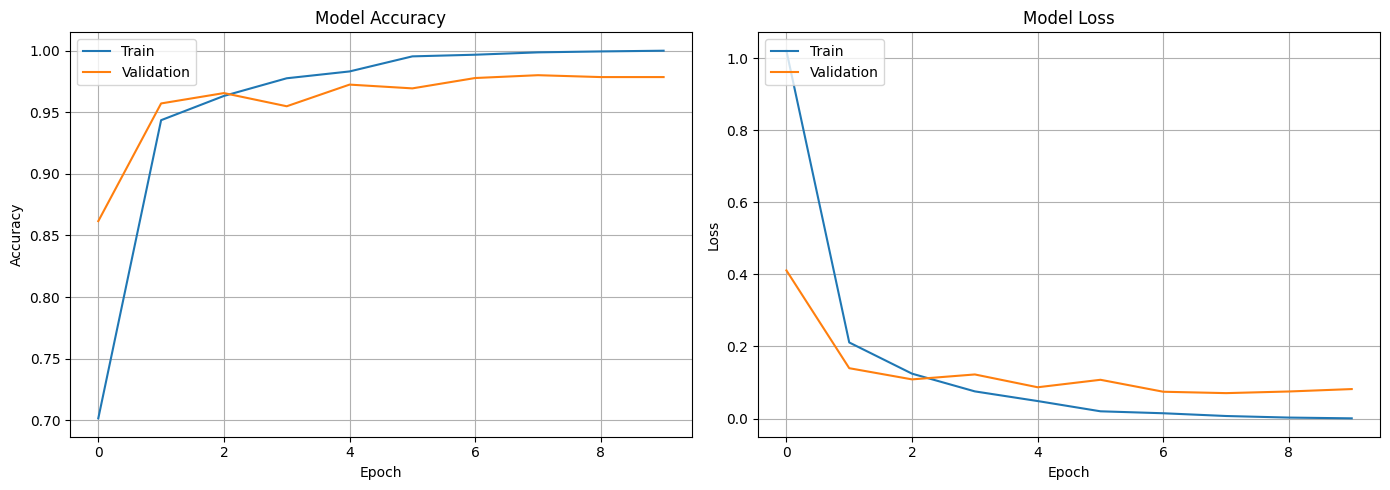


--- Evaluating Model on Test Set ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9765 - loss: 0.0882
Test Loss: 0.0859
Test Accuracy: 0.9789


In [16]:
print("\n--- Training Model ---")
# Determine epochs - start with a reasonable number (e.g., 15-25)
# Monitor the validation accuracy/loss during training to see if more/fewer are needed.
# Too few epochs -> underfitting. Too many -> overfitting.
EPOCHS = 10 # Adjust as needed based on observation
BATCH_SIZE = 32 # Common batch size

# Use a portion of the training data as validation data during training
# This helps monitor overfitting without touching the final test set
VALIDATION_SPLIT = 0.2 # Use 20% of the training data for validation

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT, # Use part of training data for validation
    verbose=1 # Show progress for each epoch
)

print("Model training finished.")

# --- 6. Show Training Metrics ---
print("\n--- Training History Metrics ---")

# Function to plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

# --- 7. Evaluate Model on Test Set ---
print("\n--- Evaluating Model on Test Set ---")
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)

print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")



--- Detailed Classification Report ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        37
     Agent.FYI       1.00      1.00      1.00        35
     Allaple.A       1.00      1.00      1.00       885
     Allaple.L       1.00      1.00      1.00       477
 Alueron.gen!J       1.00      1.00      1.00        59
     Autorun.K       1.00      1.00      1.00        32
       C2LOP.P       0.93      0.89      0.91        44
   C2LOP.gen!g       0.90      0.92      0.91        60
Dialplatform.B       1.00      1.00      1.00        53
     Dontovo.A       0.98      1.00      0.99        49
      Fakerean       1.00      1.00      1.00       114
 Instantaccess       1.00      1.00      1.00       129
    Lolyda.AA1       0.98      0.92      0.95        64
    Lolyda.AA2       0.98      1.00      0.99        55
    Lolyda.AA3       1.00      0.95      0.97        37
     Lolyda.AT       1.

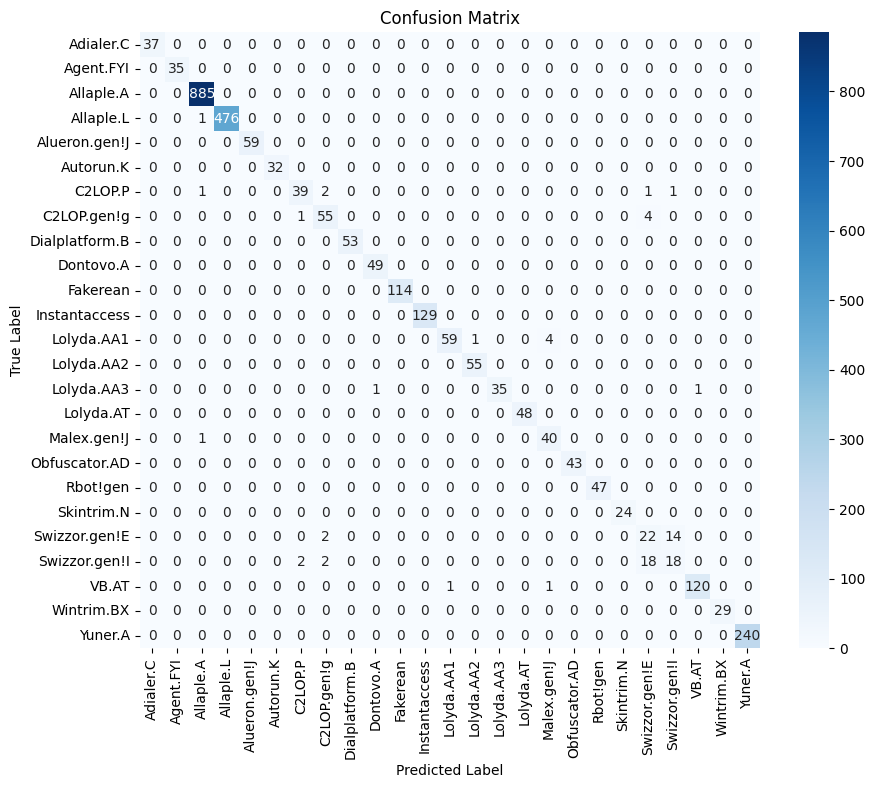

In [17]:
print("\n--- Detailed Classification Report ---")
# Get predictions on the test set
y_pred_proba = model.predict(X_test)
# Convert probabilities to predicted class index (integer)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
# Convert one-hot encoded y_test back to class index (integer)
y_test_classes = np.argmax(y_test, axis=1)

# Get class names from the label encoder
class_names = label_encoder.classes_

# Print classification report (precision, recall, f1-score per class)
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

print("\n--- Confusion Matrix ---")
# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Discusión

El modelo demostró un rendimiento excelente en la clasificación de familias de malware a partir de las imágenes, alcanzando una precisión global del 97.79% y un F1-score promedio ponderado de 0.98 sobre el conjunto de prueba. Si bien el análisis del entrenamiento sugirió la aparición de sobreajuste (overfitting) tras alcanzar un rendimiento óptimo alrededor de la época 5, la evaluación final sobre datos no vistos confirma una excelente capacidad de generalización. La alta precisión promedio indica que el modelo aprendió patrones visuales distintivos y robustos característicos de las diferentes familias de malware analizadas.

A pesar del conocido desequilibrio en el número de muestras por familia, el modelo exhibió un desempeño casi perfecto (precisión, recall y F1-score de 1.00) para la mayoría de las familias, incluyendo las más prevalentes como Allaple.A y Allaple.L, pero también varias con soporte mucho menor, como Adialer.C o Skintrim.N. Solo unas pocas familias, notablemente C2LOP.P (F1=0.86) y C2LOP.gen!g (F1=0.89), mostraron métricas ligeramente inferiores, aunque todavía altas. Este rendimiento fuerte y homogéneo en casi todas las categorías, independientemente de su frecuencia, minimiza las preocupaciones iniciales sobre el impacto del desequilibrio de clases y valida contundentemente la efectividad del enfoque CNN para esta tarea específica.


In [18]:
model.save('./results/model_no_defense.h5')

In [19]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.extraction import CopycatCNN


# We wrap the model in a TensorFlowV2Classifier
victim_clf = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    train_step=None,
    clip_values=(0.0, 1.0),
)

# We create and wrap the thief model (same architecture)
def make_thief():
    m = keras.Sequential([
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

thief_clf = TensorFlowV2Classifier(
    model=make_thief(),
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    train_step=None,
    clip_values=(0.0, 1.0),
)

# We define our query pool (can be X_train without labels)
X_pool = X_train 

# We launch the CopycatCNN attack
attack = CopycatCNN(
    batch_size_query=128,
    batch_size_fit=128,
    nb_stolen=5000,    
    nb_epochs=5,       
    classifier=victim_clf
)
stolen_clf = attack.extract(x=X_pool, thieved_classifier=thief_clf)

# We evaluate the thief on our test set
loss_s, acc_s = stolen_clf._model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print(f"Stolen Test Loss: {loss_s:.4f}, Acc: {acc_s:.4f}")

2025-05-11 22:20:55.696985: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 22:20:59.336052: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 22:21:06.987914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9545 - loss: 0.1382
Stolen Test Loss: 0.1521, Acc: 0.9565


In [24]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
import numpy as np

# Instantiate the attack, passing the victim classifier
mi_rule = MembershipInferenceBlackBoxRuleBased(classifier=victim_clf)

# Prepare the mixed dataset for inference (in=1, out=0)
X_mi = np.concatenate([X_train, X_test]) # Combine training and testing data
y_mi = np.array([1]*len(X_train) + [0]*len(X_test)) # Create labels: 1 for train, 0 for test

# Perform the membership inference attack
member_preds = mi_rule.infer(x=X_mi, y=y_mi)

# Calculate and print the accuracy of the attack
accuracy = (member_preds == y_mi).mean() # Compare predicted membership with actual membership
print(f"Rule-based membership inference accuracy: {accuracy:.3f}")

Rule-based membership inference accuracy: 0.305


In [23]:
from art.attacks.evasion import FastGradientMethod

# Configure the attack on the victim classifier
fgsm = FastGradientMethod(
    estimator=victim_clf,
    eps=0.2  # perturbation magnitude (try values between 0.05 and 0.3)
)

# Generate adversarial examples from the test set
X_test_adv = fgsm.generate(X_test)

# Evaluate the original model with these adversarial examples
loss_adv, acc_adv = model.evaluate(X_test_adv, y_test, batch_size=32, verbose=1)
print(f"Adversarial — Loss: {loss_adv:.4f}, Acc: {acc_adv:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0280 - loss: 37.1346
Adversarial — Loss: 37.6400, Acc: 0.0271
